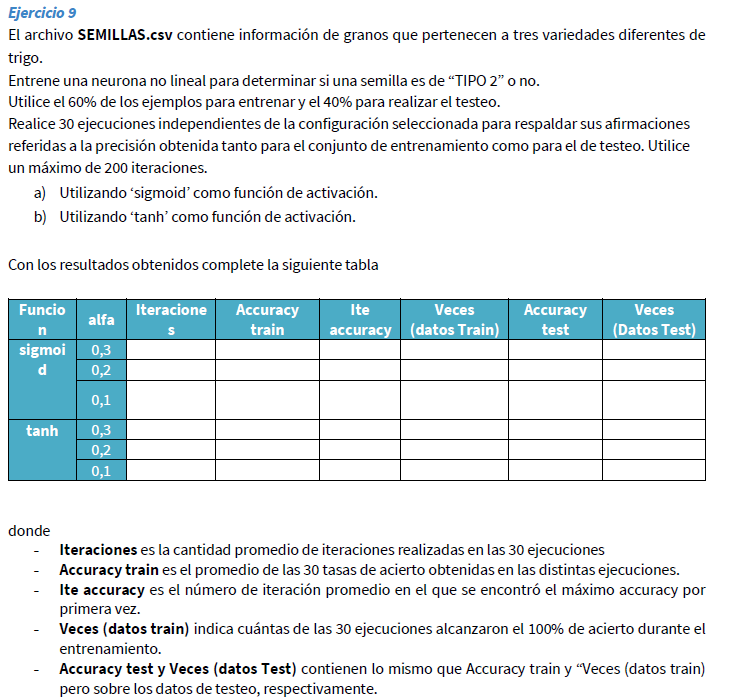

In [1]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos

nombre_archivo = DATOS_DIR + 'SEMILLAS.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

display(df)

,Area,Perimetro,Compacidad,LongNucleo,AnchoNucleo,Asimetria,LongSurco,Clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Tipo1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Tipo1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Tipo1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Tipo1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Tipo1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,Tipo3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,Tipo3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,Tipo3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,Tipo3


## Seleccion de atributos y normalizacion

In [11]:
import numpy as np
from sklearn import preprocessing, model_selection

X_raw = np.array(df.iloc[:,0:-1])  # recupera todas las columnas salvo la última (es la clase)
T_raw = np.array(df.iloc[:,-1])    # recupera solo la última columna (es la clase)

clases = np.unique(T_raw)  # obtiene las clases sin repeticiones
print('Las clases del dataset son :', clases)

# Normalizacion con media y desviacion
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X_raw)

Las clases del dataset son : ['Tipo1' 'Tipo2' 'Tipo3']


In [12]:
from ClassNeuronaGral import NeuronaGradiente

###############################################################################
# neurona no lineal sigmoid
ERROR = 1e-03
ALFA = 0.2
FUN = 'sigmoid'
MAX_ITE = 250

print('\nNeurona con %s' %FUN)

# hace entrenamiento por cada clase
for cls_name in clases:
    # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase

    T = 1 * (T_raw == cls_name)

    # Entrena perceptrón
    modelo = NeuronaGradiente(alpha=ALFA, n_iter=MAX_ITE, FUN=FUN, cotaE=ERROR)
    modelo.fit(X, T)
    (W, b, iteraciones) = (modelo.w_, modelo.b_, len(modelo.errors_))

    Y = modelo.predict(X)

    efectividad = 100.0*np.sum(Y==T)/len(Y)

    print("Clase %s con %6.2f%% de efectividad con %d iteraciones" % (cls_name, efectividad, iteraciones ))


Neurona con sigmoid
Clase Tipo1 con  93.33% de efectividad con 250 iteraciones
Clase Tipo2 con  99.52% de efectividad con 250 iteraciones
Clase Tipo3 con  97.62% de efectividad con 250 iteraciones


## Entrenamiento para clases del "Tipo 2" con **NeuronaGradiente**

In [15]:
###############################################################################
# neurona no lineal tanh
ERROR = 1e-03
ALFA = 0.2
FUN = 'sigmoid'
MAX_ITE = 300
CORRIDAS = 30
TEST_SIZE = .4

print('\nNeurona con %s' %FUN)

cls_name = 'Tipo2'
prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

if (FUN == 'tanh'):
    T = 2*(T_raw==cls_name)-1
else:
    T = (T_raw==cls_name)*1

for nro_ite in range(CORRIDAS):
    # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_raw, T, test_size=TEST_SIZE)#, random_state=42)

    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # Entrena perceptrón
    modelo = NeuronaGradiente(alpha=ALFA, n_iter=MAX_ITE, FUN=FUN, cotaE=ERROR)
    modelo.fit(X_train, Y_train)

    (W, b, iteraciones) = (modelo.w_, modelo.b_, len(modelo.errors_))

    prom_ite = prom_ite + iteraciones

    # efectividad entrenamiento
    Y_pred = modelo.predict(X_train)
    efectividad = 100.0*np.sum(Y_train==Y_pred)/len(Y_pred)
    prom_acc_train = prom_acc_train + efectividad
    if (100-efectividad<0.000001):
        veces_train = veces_train + 1

    print("Clase %s (E) con %6.2f%% de efectividad con %d iteraciones" % (cls_name, efectividad, iteraciones ))

    # efectividad prueba
    Y_pred = modelo.predict(X_test)
    efectividad = 100.0*np.sum(Y_test==Y_pred)/len(Y_pred)
    prom_acc_test = prom_acc_test + efectividad
    if (100-efectividad<0.000001):
        veces_test = veces_test + 1


print('promedio iteraciones  : %6.2f' % (prom_ite/CORRIDAS))
print('promedio acc. train   : %6.2f' % (prom_acc_train/CORRIDAS))
print('promedio acc. test    : %6.2f' % (prom_acc_test/CORRIDAS))
print('ejec. train con 100%%  : %3d' % (veces_train))
print('ejec.  test con 100%%  : %3d' % (veces_test))


Neurona con sigmoid
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 292 iteraciones
Clase Tipo2 (E) con  98.41% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 246 iteraciones
Clase Tipo2 (E) con 100.00% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 154 iteraciones
Clase Tipo2 (E) con  98.41% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  98.41% de efectividad con 284 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con  99.21% de efectividad con 300 iteraciones
Clase Tipo2 (E) con 100.00% de efe

## Entrenamiento para clases del "Tipo 2" con **NeuronaGradiente** Modularizado

In [19]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
import numpy as np

def entrenar_neurona_no_lineal(
        t_raw, x_raw,
        error=1e-03, alfa=0.2, fun='sigmoid',
        max_ite=200, corridas=30, test_size=0.4,
        scaler=None):
    print('\nNeurona con %s' % fun)
    prom_ite = 0
    prom_acc_train = 0
    prom_acc_test = 0
    veces_train = 0
    veces_test = 0
    for nro_ite in range(corridas):
        # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_raw, t_raw, test_size=test_size)
        if scaler is not None:
          x_train = scaler.fit_transform(x_train)
          x_test = scaler.transform(x_test)

        # Entrena perceptrón
        modelo = NeuronaGradiente(alpha=alfa, n_iter=max_ite, FUN=fun, cotaE=error)
        modelo.fit(x_train, y_train)
        w, b, iteraciones = modelo.w_, modelo.b_, len(modelo.errors_)
        prom_ite += iteraciones
        # efectividad entrenamiento
        y_pred = modelo.predict(x_train)
        efectividad = 100.0 * np.sum(y_train == y_pred) / len(y_pred)
        prom_acc_train += efectividad
        if 100 - efectividad < 0.0000001:
            veces_train += 1
        print("Corrida %2d (E): %6.2f%% de efectividad con %d iteraciones" % (nro_ite+1, efectividad, iteraciones))

        # efectividad prueba
        y_pred = modelo.predict(x_test)
        efectividad = 100.0 * np.sum(y_test == y_pred) / len(y_pred)
        prom_acc_test += efectividad
        if 100 - efectividad < 0.0000001:
            veces_test += 1


    print('Promedio iteraciones  : %6.2f' % (prom_ite / corridas))
    print('Promedio acc. train   : %6.2f' % (prom_acc_train / corridas))
    print('Promedio acc. test    : %6.2f' % (prom_acc_test / corridas))
    print('Ejecuciones train con 100%%  : %3d' % (veces_train))
    print('Ejecuciones test con 100%%  : %3d' % (veces_test))


###############################################################################
# neurona no lineal tanh
ERROR = 1e-03
ALFA = 0.2
FUN = 'tanh'
MAX_ITE = 300
CORRIDAS = 30
TEST_SIZE = .4

cls_name = 'Tipo2'
prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

if (FUN == 'tanh'):
    T = 2*(T_raw==cls_name)-1
else:
    T = (T_raw==cls_name)*1

scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()

# Ejemplo de uso de la función
# Asegúrate de definir T_raw, X_raw, y la clase NeuronaGradiente antes de llamar a la función
entrenar_neurona_no_lineal(T, X_raw,
        error=ERROR, alfa=ALFA, fun=FUN,
        max_ite=MAX_ITE, corridas=CORRIDAS, test_size=TEST_SIZE,
        scaler=scaler)



Neurona con tanh
Corrida  1 (E): 100.00% de efectividad con 236 iteraciones
Corrida  2 (E):  99.21% de efectividad con 73 iteraciones
Corrida  3 (E): 100.00% de efectividad con 300 iteraciones
Corrida  4 (E): 100.00% de efectividad con 269 iteraciones
Corrida  5 (E): 100.00% de efectividad con 300 iteraciones
Corrida  6 (E): 100.00% de efectividad con 300 iteraciones
Corrida  7 (E): 100.00% de efectividad con 211 iteraciones
Corrida  8 (E): 100.00% de efectividad con 300 iteraciones
Corrida  9 (E):  99.21% de efectividad con 300 iteraciones
Corrida 10 (E): 100.00% de efectividad con 242 iteraciones
Corrida 11 (E): 100.00% de efectividad con 274 iteraciones
Corrida 12 (E): 100.00% de efectividad con 300 iteraciones
Corrida 13 (E): 100.00% de efectividad con 115 iteraciones
Corrida 14 (E): 100.00% de efectividad con 134 iteraciones
Corrida 15 (E): 100.00% de efectividad con 300 iteraciones
Corrida 16 (E): 100.00% de efectividad con 300 iteraciones
Corrida 17 (E): 100.00% de efectividad 